# Construction d'un système de recommandation

Nous avons décidé d'orienter notre projet sur la recommendation de films.
En effet durant ce confinement, nous avons eu le temps de visionner beaucoup de films,
mais nous nous sommes rendus compte que nous passions quasiment autant de temps
à choisir le film qu'à le regarder. D'où la nécessité de créer un système de re-
commendations afin d'optimiser notre temps de visionnage.
Nous avons chercher une base de données assez exploitable afin de mener à bien
notre projet. Nous nous sommes basés sur la base de données de 'The Movies Dataset'.

# Différents systèmes de recommandation

- [x] popularity based = moyenne simple
- [x] memory-based (user- et item- based)
- [x] hybride : popularity/collabo
- [x] clustering
- [ ] hybride : cluster/collabo
- model-based (matrix factorisation, optimisation avec descente de gradient)
    - [x] descente de gradient
    - [ ] cross-validation pour tuner les hyperparamètres
- [ ] hybride : cluster/model
- [ ] user-centered linear approach = descente de gradient (même pb d'opti que model-based, mais on donne les infos des films)

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import re
from time import time
from ast import literal_eval

In [2]:
#%load_ext line_profiler

## Fetching and cleaning data

Nous utilisons deux tables de données. L'une, *movies_metadata.csv*, contient une liste de films et des informations relativesau genre, date de sortie etc. 

In [3]:
movies = pd.read_csv("movies_metadata.csv")
ratings = pd.read_csv("ratings_small.csv")
keywords = pd.read_csv("keywords.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")
link = pd.read_csv("links_small.csv")

C:\Users\mathi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
movies.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [5]:
ratings.sort_values(by='movieId').head()

,userId,movieId,rating,timestamp
9713,68,1,4.0,1194741818
35933,261,1,1.5,1101665532
52631,383,1,5.0,852806429
35983,262,1,2.5,1433898798
12038,77,1,4.0,1163005363


In [6]:
link.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [8]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [9]:
def filter_correct_id(word):
    if not isinstance(word, str) or re.fullmatch(r'[0-9]+', word):
        return word
    return "wrong_id"

In [10]:
def simplify_genre(l):
    if len(l) <= 0 :
        return []
    if isinstance(l[0], dict):
        return [d['name'] for d in l]
    return l

In [11]:
# do not re-run !

movies = movies.drop_duplicates('id')
keywords = keywords.drop_duplicates('id')
credits = credits.drop_duplicates('movie_id')

movies.id = movies.id.apply(filter_correct_id)
movies = movies[movies.id != "wrong_id"]
movies.id = movies.id.astype('int64')
movies[movies['vote_count'].notnull()]['vote_count'].astype('int64', copy=False)
movies[movies['vote_average'].notnull()]['vote_average'].astype('int64', copy=False)


movies = movies.rename(columns={'id' : 'tmdbId'})
keywords = keywords.rename(columns={'id' : 'tmdbId'})
credits = credits.rename(columns={'movie_id' : 'tmdbId'})

## Top films par genres

Une méthode simple pour recommander des films à un utilisateur, est de lui présenter la liste des films les plus populaires appartenant à ses genres préférées. Ainsi il faudra dans un premier temps identifier ses genres préférés, puis établir la liste des films les plus populaires qui figurent parmi ces genres.

Notre classs `PopularityRecommender` construit tout d'abord les tables qui vont nous être utiles. La dataframe `dfm` de schéma *dfm(title, vote_average, vote_count)* contient la liste des films identifiés par leur `movieId`. Pour pouvoir sélectionner les films par genre, et parce qu'un film peut appartenir à plusieurs genres, nous utlisont également une table `sgr` dans laquelle chaque ligne n'indique qu'un seul genre du film. Indexer ces deux tables par l'attribut `movieId` nous permet d'accélerer la sélection des lignes puisqu'elle ne se fait presque que par `movieId`.

Enfin, la table `dfm` contenant les notes des utilisateurs et des films est utilisée pour déterminer les genres préféres d'un user donné : la méthode `pref_genres` selectionne les genres des 3 films préférés de l'utilisateurs. 


Pour évaluer la popularitée d'un film au sein d'un catégorie de films, nous utilisons la formule de *weighted rating* utilisée par le site TMDB : 
$$
WR = \frac{v}{v + m} R + \frac{m}{v +m} C
$$

où 
- $R$ est la note moyenne du film (vote_average) ;

- $v$ est le nombre de notes que le film a reçu (vote_count) ; 

- $m$ est le nombre minimum de votes qu'un film doit recevoir pour pouvoir figurer sur la liste ;

- $C$ est la note moyenne pour tous les films.


Si $R$, $v$ et $C$ se calculent à partir des données, il nous faut choisir le seuil $m$. Nous allons considérer qu'un film doit avoir eu plus de votes qu'au moins 80% des films pour pouvoir aparaître dans le top du genre. Ce paramètre permet de ne considérer que des films qui ont été vu par une majorité de personnes et qui peuvent être donc considérés comme populaire. 

La méthode `best` calcule donc ce critère de popularité pour les films appartenant à une liste de genres données et renvoie les meilleurs. Il suffit ensuite (dans la méthode `recommend`) de filtrer cette liste par les films non encore visionnés par l'utilisateur.


In [12]:
def weighted_rating(x, m, C):
        '''
        x[:, 0] correspond à vote_count
        x[:, 1] correspond à vote average
        '''
        v = x[:, 0]
        R = x[:, 1]
        return np.multiply(v/(v+m), R) + np.multiply(m/(m+v), C)

In [13]:
class PopularityRecommender:
    def __init__(self, movies, ratings, link):
        self.dfm = movies[['tmdbId', 'title', 'genres', 'vote_average', 'vote_count']]
        self.dfm = link.merge(self.dfm, left_on='tmdbId', right_on='tmdbId').drop(columns=['tmdbId', 'imdbId'])
        self.dfm.set_index('movieId', inplace=True)
        self.dfm['genres'] = self.dfm['genres']\
                    .apply(lambda x: literal_eval(x) if isinstance(x, str) else x)\
                    .apply(simplify_genre)

        self.dfr = ratings[['userId', 'movieId', 'rating']]
        
        self.sgr = self.dfm.apply(lambda x: pd.Series(x['genres'], dtype='str'),axis=1).stack().reset_index(level=1, drop=True)
        self.sgr.name = 'genre'
    
        
    def recommend(self, uid, n=20):
        '''
        Retourne les n films les plus populaires appartenant aux genres préféres de l'user uid
        '''
        chart = self._best_(self.pref_genres(uid), n*10)
        watched_movies = (self.dfr).loc[self.dfr['userId'] == uid].movieId.unique()
        watched_movies = chart.index.isin(watched_movies)
        chart = chart.loc[~watched_movies]
        return chart.head(n) if chart.shape[0] > n else chart
    
    def pref_genres(self, uid):
        '''
        Retourne les genres des 3 films préférés de l'user uid
        '''
        rats = self.dfr.loc[self.dfr['userId'] == uid].sort_values(by='rating')
        pref = rats.head(3)['movieId'] if rats.shape[0] > 5 else rats['movieId']
        genres = []
        for g in self.dfm.loc[pref.values].genres :
            genres = list(set(genres) | set(g))
        return genres

    def _best_(self, genres, k=200):
        # select movies that are in genres
        dfg = self.sgr[self.sgr.isin(genres)]
        dfg = self.dfm.loc[dfg.index]
        # need to drop duplicates : a movie can be selected because 2 or more of its genres are ok
        dfg = dfg.loc[~dfg.index.duplicated()]

        C = dfg.vote_average.mean()
        m = dfg.vote_count.quantile(0.8)

        top = dfg[(dfg['vote_count'] >= m)]
        top['wr'] = weighted_rating(top[['vote_count', 'vote_average']].to_numpy(), m, C)
        top.sort_values('wr', ascending=False, inplace=True)
        top.drop(columns=['vote_count', 'vote_average'], inplace=True)
        return top.head(k)

In [14]:
%timeit pop = PopularityRecommender(movies, ratings, link)

10 s ± 319 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
pop = PopularityRecommender(movies, ratings, link)
print(pop.pref_genres(100))
pop.recommend(100, 10)

['Animation', 'Comedy', 'Adventure', 'Family']


C:\Users\mathi\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mathi\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mathi\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,title,genres,wr
movieId,,,
356,Forrest Gump,"[Comedy, Drama, Romance]",8.071183
5618,Spirited Away,"[Fantasy, Adventure, Animation, Family]",8.039999
1196,The Empire Strikes Back,"[Adventure, Action, Science Fiction]",8.029038
79132,Inception,"[Action, Thriller, Science Fiction, Mystery, A...",8.027219
2324,Life Is Beautiful,"[Comedy, Drama]",8.019944
92259,The Intouchables,"[Drama, Comedy]",8.012229
109487,Interstellar,"[Adventure, Drama, Science Fiction]",8.009342
7153,The Lord of the Rings: The Return of the King,"[Adventure, Fantasy, Action]",7.978825
260,Star Wars,"[Adventure, Action, Science Fiction]",7.954947


In [16]:
ratings.loc[ratings['userId']==100]

,userId,movieId,rating,timestamp
15273,100,1,4.0,854193977
15274,100,3,4.0,854194024
15275,100,6,3.0,854194023
15276,100,7,3.0,854194024
15277,100,25,4.0,854193977
15278,100,32,5.0,854193977
15279,100,52,3.0,854194056
15280,100,62,3.0,854193977
15281,100,86,3.0,854194208
15282,100,88,2.0,854194208


In [17]:
print(pop.pref_genres(4))
pop.recommend(4, 10)

['Crime', 'Thriller', 'Comedy', 'Action', 'Adventure']


C:\Users\mathi\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mathi\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,title,genres,wr
movieId,,,
318,The Shawshank Redemption,"[Drama, Crime]",8.344048
58559,The Dark Knight,"[Drama, Action, Crime, Thriller]",8.201043
5618,Spirited Away,"[Fantasy, Adventure, Animation, Family]",8.022190
79132,Inception,"[Action, Thriller, Science Fiction, Mystery, A...",8.021702
109487,Interstellar,"[Adventure, Drama, Science Fiction]",8.002558
2324,Life Is Beautiful,"[Comedy, Drama]",8.001034
92259,The Intouchables,"[Drama, Comedy]",7.998925
1221,The Godfather: Part II,"[Drama, Crime]",7.984395
7153,The Lord of the Rings: The Return of the King,"[Adventure, Fantasy, Action]",7.969959


# <span style="color:red"> À blablater : méthode pas personalisée, privilégie les plus populaires et ne permet pas d'évaluer de manière quantitative la pertinence (pas de note)
</span>

## Collaborative filtering : user- et item- based

Pour prédire la note d'un couple (*user*, *movie*) on peut regarder quelle note les utilisateurs similaires à *user* ont donné à ce film et faire une moyenne de leurs notes. On peut également regarder quelle note *user* a donné à des films similaires à *movie*. La première approche est centré sur les utilisateurs, *user-based*, tandis que la deuxième est centrée sur les films, *item-based*. Neánsmoins les deux approches suivent la même logique et nous allons implémenter des fonctions qui s'adaptent en fonction de l'approche choisie. Dans un système *user-based*, nous allons appeler **peers** les **users** et **others** les **items**. Dans un système *item-based* c'est l'inverse.



Deux utilisateurs sont considérés comme similaires s'ils ont les mêmes préférences de films. Il semble en effet plus pertinent de demander à un utilisateurs aux goûts similaires à *user* de lui conseiller un film. Pour comparer deux utilisateurs il faudra donc regarder les notes qu'ils ont donné aux mêmes films. De manière analogue, deux films sont similaires s'ils sont appréciés par les mêmes utilisateurs. Il faudra donc regarder les notes données par les mêmes utilisateurs pour comparer deux films. Cette notion de similitude sera calculée par un taux de corrélation.

Nous allons considérer une variable globale `cm_user` et `cm_movie` contenant la matrice de correlation entre utilisateurs et films. 

### Normalisation des notes

Nous n'avons besoin pour ce système que des notes données par les utilisateurs. Puisque la moyenne des notes données varie d'un utilisateur à un autre et d'un film à un autre, nous allons translater les notes afin que la moyenne des notes se trouve à 0. En *user-based*, on considère la moyenne par utilisateur, tandis qu'en *item-based* on s'interèsse à la moyenne par film. Par abus de langage nous appelons ces nouvelles notes les notes *normalisées*. 

Résultat : mean en tant que numpy array bien plus efficace

### Calculer la matrice de corrélation


Dans un système *user-based*, on note $I_u$ l'ensemble des items renseignés pour l'utilisateur $u$ et $U_k$ l'ensemble des utilisateurs qui ont notés le film $k$. On note $I_{uv} = I_u \cap I_v$. Pour le *item-based* on utilisera les mêmes notations en intervertissant user et item. On notera également $S_{ui}$ la note normalisée de l'item *i* donnée par l'utilisateur *u*. 


Pour déterminer si deux utilisateurs se ressemblent en termes de goûts, nous utilisons un taux de corrélation sur les avis données. Nous allons comparer quatres taux de corrélations différents. Le premier ```cor()``` calcule le taux de corrélation classique donné par la formule :
$$
cor(u, v) = \frac{\sum_{k \in I_{uv}} s_{uk} s_{vk}}{\sqrt{\sum_{k \in I_{uv}} s_{uk}^2}\sqrt{\sum_{k \in I_{uv}} s_{vk}^2}}
$$

Le taux de corrélation ajusté ```cor_adj()``` permet de ne pas donner trop d'importance aux films populaires que beaucoup de personnes ont vu.
$$
cor\_adj(u, v) = \frac{\sum_{k \in I_{uv}} s_{uk} s_{vk} / U_k}{\sqrt{\sum_{k \in I_{uv}} \frac{s_{uk}^2}{|U_k|}}\sqrt{\sum_{k \in I_{uv}} \frac{s_{vk}^2}{|U_k|}}}
$$

Le taux de correlation calculé par ```cor_dis()``` permet de ne pas donner une correlation trop élevée si les deux utilisateurs n'ont pas donné assez d'avis sur des films en commun. 
$$
cor\_dis(u, v) = cor(u, v) * \frac{min(|I_{uv}|, \beta)}{\beta}
$$

Enfin la fonction ```cor_dis_adj()``` fait un mélange des deux dernières amélioration : il filtre les films trop populaire et n'apporte de l'importance seulement si deux personnes ont données leur avis sur un certain nombre de films.

$$
cor\_dis(u, v) = cor\_adj(u, v) * \frac{min(|I_{uv}|, \beta)}{\beta}
$$

Nous construisons maintenant la matrice de correlation. Puisqu'une telle matrice est symétrique, nous avons préféré utiliser une dataframe à deux entrées et ainsi ne stocker la corrélation pour un couple qu'une seule fois. En procédant comme tel, l'ordre dans lequel on désigne un couple peer-peer sera important. Pour faciliter l'accès, nous trions d'abord la datframe `df` pour que les peers soient pris dans l'ordre croissant des id. Ainsi les doubles indices de la dataframe construite auront tous la propriété que le premier indice est strictement inférieur au deuxième. Lors de l'accès à la correlation entre deux peers *u et v* il suffira de les ranger dans le bon ordre.

La fonction de corrélation à utiliser peut être précisée en argument et par défaut la fonction choisie est la corrélation classique.

Nous utilisons également le module logging pour suivre le déroulement du calcul. Celui-ci peut être très long en fonction de la taille des données et en rappelant tous les 10 peers qu

Comme le calcul de la matrice peut-être très long, afin d'voir un suivi du déroulement du calcul, on utilise le module logging. Cette fonctionalité est désactivée par défaut. 

### Prédiction

Pour prédire la note donnée par un utilisateur à un film, nous allons faire un moyenne des notes données pour les k peer les plus proches. Dans une approche user-based, on regarde donc les k plus proches utilisateurs, dans une approche item-based, les k films les plus proches. Les plus proches sont ceux qui ont une corrélation la plus élevée. On appelle **p** le peer et **o** l'élément other.

La moyenne effectuée est pondérée par les coefficients de corrélations. On ajoute également la moyenne des notes de **p** pour retrouver une note non normalisée.


$$
\hat{\sigma}_{um} = \mu_u + \frac{\sum_{v \in P_u(m)} s_{vm} \cdot cor(u, v)}{\sum_{v \in P_u(m)} |cor(u,v)|}
$$

# <span style="color:red">Pourquoi utiliser un parsing fait maison et pas knn non parametré comme tout le monde sur internet ?</span>

# <span style="color:red">Que faire si sum_dow == 0 ? + prédire une note possible ?</span> 

# <span style="color:red"> on donne quoi comme correlation si su et/ou sv est nul ? J'ai mis 0 par défaut mais bon ...
</span>

In [18]:
def tx_cor(u, v, dfr, base):
    '''
    :param: u, v - les id des peers (user ou movie) à comparer
            base - un indicateur dy type de recommandation utilisé : 'user' ou 'movie'
    :return: le taux de corrélation classique entre u et v.
    '''
    Iu = dfr.loc[u, :]
    Iv = dfr.loc[v, :]
    Iuv = list(set(Iu.index) & set(Iv.index))
    if not len(Iuv) : # l'intersection est vide
        return float('nan')

    su = Iu.loc[Iuv]
    sv = Iv.loc[Iuv]
    su = su['rating_norm_'+base].to_numpy()
    sv = sv['rating_norm_'+base].to_numpy()
    
    up = np.dot(su, sv)
    down = math.sqrt(np.dot(su, su) * np.dot(sv, sv))

# default value to change
    if up == 0 or down == 0:
        return 0
    return up / down

# <span style="color:red">À adapter encore</span>

In [19]:
def cor_adj(u, v, df, Iuv):
    nb_rat = df.loc[:, ['movieId', 'rating']].groupby(['movieId']).count()
    
    sum_up = 0
    sum_down_u = 0
    sum_down_v = 0
    for movie in Iuv.movieId.unique() :
        suk = df.loc[(df['userId'] == u) & (df['movieId'] == movie), ['rating_norm_'+base]]
        svk = df.loc[(df['userId'] == v) & (df['movieId'] == movie), ['rating_norm_'+base]]
        suk, svk = float(suk), float(svk)
        
        sum_up += suk * svk / nb_rat.at[movie, 'rating']
        sum_down_u += suk**2 /  nb_rat.at[movie, 'rating']
        sum_down_v += svk**2 /  nb_rat.at[movie, 'rating']
    return sum_up / math.sqrt(sum_down_u * sum_down_v)

In [20]:
def cor_dis(u, v, df, Iuv):
    beta = 20
    correlation = cor(u, v, df, Iuv)
    return correlation * min(len(Iuv), beta)/beta

In [21]:
def cor_dis_adj(u, v, df, Iuv):
    beta = 20
    correlation = cor_adj(u, v, df, Iuv)
    return correlation * min(len(Iuv), beta)/beta

In [22]:
class MemoryBasedPredictor:
    def __init__(self, base):
        assert base in {'user', 'movie'}
        self.base = base
        self.ptype, self.otype = ('userId', 'movieId') if self.base == 'user' else ('movieId', 'userId')
        self.dfr = None
        self.cm = None
        self.id_index = None
        self.mean_peers = None
    
    def fit(self, ratings, cor_fct, verbose=False):
        assert 'userId' in ratings.columns and  'movieId' in ratings.columns
        
        self.dfr = ratings[['userId', 'movieId', 'rating']].set_index([self.ptype, self.otype])
        self.dfr.sort_index(inplace=True)

        # normalize ratings per peer
        self.mean_peers = self._normalize_()
        
        # construction of the correlation matrix
        self.cm, self.id_index = self._CorMatrix_(cor_fct, verbose)

    def predict(self, p, o, k=4):
        '''
        Retourne la prédiction de la note du couple (p, o) utilisant un peer-groupe de taille k
        '''
        assert self.dfr is not None, "This MemoryBasedPredictor instance is not fitted yet. \
                                                Call 'fit' with appropriate arguments before using this estimator."
        
        mu = self.mean_peers[p]
        peers = self._PeerGroup_(p, o, k)

        sum_up, sum_down = 0, 0
        for friend in peers:
            cor = self.get_cor(p, friend)
            if not math.isnan(cor):
                sfo = self.dfr.loc[(friend, o), 'rating_norm_'+self.base]
                sfo = 0 if len(sfo) <= 0 else float(sfo)
                sum_up += sfo * cor
                sum_down += abs(cor)

        sum_down = 1 if sum_down == 0 else sum_down
        pred = mu + sum_up / sum_down

        # note prédite à une précision de 0.5
        pred = round(2 * pred) / 2
        # note prédite se trouve entre 0 et 5
        pred = 5 if pred > 5 else pred
        pred = 0 if pred < 0 else pred

        return pred
    
        
    def score(test_ratings, k=4):
        assert self.dfr is not None, "This MemoryBasedPredictor instance is not fitted yet. \
                                                Call 'fit' with appropriate arguments before using this estimator."
        dft = test_ratings.set_index([self.ptype, self.otype])
        predictions = [self.pred(p, o, k) for (p, o) in list(dft.index)]
        truth = dft['rating'].to_numpy()
        
        return 1 - math.sqrt(sum((prediction - truth)**2))
    
    
    
    def get_cor(self, u, v):
        '''
        Retourne le taux de correlation entre u et v
        '''
        ixu, ixv = np.argwhere(self.id_index == u), np.argwhere(self.id_index == v)
        if len(ixu) and len(ixv) :
            return self.cm[ixu[0, 0], ixv[0, 0]]
        return float('nan')
    
    
    def _normalize_(self):
        '''
        Ajoute une colonne dans la dataframe df contenant les notes normalisées des utilisateurs
        Retourne la Série donnant la moyenne des notes par peer
        '''
        mean = self.dfr.groupby(self.ptype).mean()['rating']
        new_col = 'rating_norm_'+self.base
        self.dfr[new_col] = self.dfr.apply(lambda row : row[0]- mean[row.name[0]] , axis=1) 
        return mean
    
    def _CorMatrix_(self, cor_fct, verbose=False):
        '''
        Retourne la matrice de corrélation entre peers
        '''
        peers = self.dfr.index.get_level_values(self.base+'Id').unique()
        nb_peers = len(peers)

        if verbose:
            logger = logging.getLogger()
            logger.setLevel(logging.INFO)
            logging.info('nb of peers: {}'.format(nb_peers))

        cor_mat = np.empty((nb_peers,nb_peers))
        cor_mat[:] = np.nan

        for i in range(nb_peers):
            u = peers[i]
            if verbose and not i % 10 : 
                logging.info('peer nb: {} (id {})'.format(i, u))
            for j in range(i + 1, nb_peers):
                v = peers[j]
                tx_cor = cor_fct(u, v, self.dfr, self.base)
                if not np.isnan(tx_cor):
                    cor_mat[i, j] = tx_cor
                    cor_mat[j, i] = cor_mat[i, j]
        return cor_mat, peers
    
    def _PeerGroup_(self, p, o, k=4):
        '''
        Retourne les k peers les plus proches de p
        '''
        # in user-based, get users that rated the movie o
        peers = self.dfr.loc[(slice(None), o), :]
        peers = peers.index.get_level_values(self.ptype).unique()
        
        top = [(float('-inf'), p)] * k
        for v in peers:
            taux = self.get_cor(p, v)
            if taux > top[-1][0] :
                top += [(taux, v)]
                top.sort(reverse=True)
                top = top[:-1]
        return [t[1] for t in top]

In [23]:
# test fit fonctionne
user_based = MemoryBasedPredictor('user')
%timeit user_based.fit(ratings.sample(1000), tx_cor, verbose=True)

INFO:root:nb of peers: 364
INFO:root:peer nb: 0 (id 3)
INFO:root:peer nb: 10 (id 21)
INFO:root:peer nb: 20 (id 41)
INFO:root:peer nb: 30 (id 63)
INFO:root:peer nb: 40 (id 85)
INFO:root:peer nb: 50 (id 110)
INFO:root:peer nb: 60 (id 126)
INFO:root:peer nb: 70 (id 143)
INFO:root:peer nb: 80 (id 159)
INFO:root:peer nb: 90 (id 179)
INFO:root:peer nb: 100 (id 201)
INFO:root:peer nb: 110 (id 220)
INFO:root:peer nb: 120 (id 242)
INFO:root:peer nb: 130 (id 258)
INFO:root:peer nb: 140 (id 275)
INFO:root:peer nb: 150 (id 294)
INFO:root:peer nb: 160 (id 309)
INFO:root:peer nb: 170 (id 333)
INFO:root:peer nb: 180 (id 360)
INFO:root:peer nb: 190 (id 380)
INFO:root:peer nb: 200 (id 397)
INFO:root:peer nb: 210 (id 417)
INFO:root:peer nb: 220 (id 434)
INFO:root:peer nb: 230 (id 451)
INFO:root:peer nb: 240 (id 466)
INFO:root:peer nb: 250 (id 478)
INFO:root:peer nb: 260 (id 493)
INFO:root:peer nb: 270 (id 510)
INFO:root:peer nb: 280 (id 524)
INFO:root:peer nb: 290 (id 543)
INFO:root:peer nb: 300 (id 562

2min 2s ± 5.23 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
# user_based.fit(ratings.sample(1000), tx_cor)
# user_based.predict(2, 1)

## Modèle hybride : popularité par genre et collaborative filtering

La méthode précédente permet de prédire une note, mais nous aimerions pouvoir recommander des films à un utilisateurs qu'il est susceptible d'aimer. Pour cela il faudrait prédire la note qu'il donnerait à tous les films qu'il n'a pas encore noté et prélever ceux dont la note prédite est la plus élevée. Ceci serait beaucoup trop coûteux. Une première solution est de ne considérer que des films appartenant à ses genres préférés. Ceci risque d'être toujours trop coûteux, alors nous allons nous restreindre qu'aux films les plus populaires dans ses genres préférés.

In [25]:
class MemoryPopularityRecommender:
    def __init__(self, base):
        self.memory = MemoryBasedPredictor(base)
        self.popularity = None
    
    def fit(self, movies, ratings, link, cor_fct, verbose=False):
        self.popularity = PopularityRecommender(movies, ratings, link)
        
        self.memory.fit(ratings, cor_fct, verbose)
    
    def recommend(self, uid, nb_reco=20, k=4):
        dfm_filtered = self.popularity.recommend(uid, nb_reco*10)
        
        predictions = pd.DataFrame(columns=['movieId', 'predict_rating'])
        for mid in dfm_filtered.index.unique():
            p, o = (uid, mid) if self.memory.base == 'user' else (mid, uid)
            rat = (self.memory).predict(p, o, k)
            predictions = predictions.append({'movieId':int(mid), 'predict_rating':rat}, ignore_index=True)
        
        predictions.sort_values(by='predict_rating', ascending=False, inplace=True)
        reco = dfm_filtered.join(predictions.set_index('movieId'))
        reco = reco.head(nb_reco) if reco.shape[0] > nb_reco else reco
        return reco

In [26]:
hybride = MemoryPopularityRecommender('user')
%time hybride.fit(movies, ratings.sample(1000), link, tx_cor, verbose=True)

INFO:root:nb of peers: 382
INFO:root:peer nb: 0 (id 3)
INFO:root:peer nb: 10 (id 19)
INFO:root:peer nb: 20 (id 34)
INFO:root:peer nb: 30 (id 49)
INFO:root:peer nb: 40 (id 68)
INFO:root:peer nb: 50 (id 86)
INFO:root:peer nb: 60 (id 97)
INFO:root:peer nb: 70 (id 118)
INFO:root:peer nb: 80 (id 131)
INFO:root:peer nb: 90 (id 148)
INFO:root:peer nb: 100 (id 161)
INFO:root:peer nb: 110 (id 182)
INFO:root:peer nb: 120 (id 199)
INFO:root:peer nb: 130 (id 217)
INFO:root:peer nb: 140 (id 238)
INFO:root:peer nb: 150 (id 250)
INFO:root:peer nb: 160 (id 265)
INFO:root:peer nb: 170 (id 279)
INFO:root:peer nb: 180 (id 297)
INFO:root:peer nb: 190 (id 313)
INFO:root:peer nb: 200 (id 346)
INFO:root:peer nb: 210 (id 370)
INFO:root:peer nb: 220 (id 387)
INFO:root:peer nb: 230 (id 414)
INFO:root:peer nb: 240 (id 427)
INFO:root:peer nb: 250 (id 443)
INFO:root:peer nb: 260 (id 462)
INFO:root:peer nb: 270 (id 477)
INFO:root:peer nb: 280 (id 497)
INFO:root:peer nb: 290 (id 511)
INFO:root:peer nb: 300 (id 527)


Wall time: 2min 20s


In [27]:
#hybride.recommend(241)

Cette solution présente néanmoins un désavantage. Premièrement, seuls les films les plus populaires sont considérés, leur donnant plus de visibilté parmis les utilisateurs. Ainsi un nouveau film qui n'aura pas beaucoup été vu aura que peut de chance d'être recommandé par assez populaire. Le deuxième problème est que cette méthode regroupe les films par genres. Or ce qui caractérise un film est plus vaste que seulement la case dans laquelle il s'inscrit et peut dépendre du réalisateur, du lieu de tournage ou de pleins d'autres facteurs. C'est ici que le *clustering* nous vient en aide. Cela permet de regrouper les films selon leurs similitudes issues de méta-informations et ainsi d'affiner la recherche.

## Clustering des films

### Nettoyage de la base de données et réduction de la matrice aux caractéristiques interéssantes

Suppression des id incorrects, des valeurs abérrantes, des lignes avec NaN, et modification des valeurs pour les rendre plus faciles à traiter.

On sélectionne les attributs de films qui semblent pertinents pour différencier les films sur leur contenu.
Ces choix sont arbitraires et on pourra être amenés à réfléchir dessus et à les modifier.

Nous ne voulons garder que les films ayant reçu une note. Cela est une manière de ne garder qu'un nombre limité de films (il est très compliqué pour nous d'effectuer des calculs pour 45 000 films). De plus le clustering est intéressant pour renforcer la recommendation "user-based". On ne garde donc que les films ayant été notés par les utilisateurs. Ensuite on rajoute l'attribut keywords aux films.

In [28]:
dfm_cluster = movies.join(link.set_index('tmdbId'), on='tmdbId', how='inner')

In [29]:
dfm_cluster = dfm_cluster.merge(ratings.drop_duplicates('movieId'), how='inner')

In [30]:
credits = credits [['tmdbId','crew']]
dfm_cluster = dfm_cluster.join(credits.set_index('tmdbId'), on='tmdbId', how='inner')

In [31]:
dfm_cluster = dfm_cluster.join(keywords.set_index('tmdbId'), on='tmdbId', how='inner')

In [32]:
title_id = dfm_cluster[['tmdbId','movieId','title']]
cluster_features = dfm_cluster[['title','movieId', 'genres', 'keywords','crew', 'release_date', 'production_countries', 'original_language', 'runtime']]
cluster_features = cluster_features.dropna()
cluster_features.head()

,title,movieId,genres,keywords,crew,release_date,production_countries,original_language,runtime
0,Toy Story,1,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{""credit_id"": ""52fe4284c3a36847f8024f55"", ""de...",1995-10-30,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,81.0
9,GoldenEye,10,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","[{'id': 701, 'name': 'cuba'}, {'id': 769, 'nam...","[{""credit_id"": ""52fe426ec3a36847f801e16f"", ""de...",1995-11-16,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",en,130.0
10,The American President,11,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 833, 'name': 'white house'}, {'id': 84...","[{""credit_id"": ""52fe44dac3a36847f80adfa3"", ""de...",1995-11-17,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,106.0
13,Nixon,14,"[{'id': 36, 'name': 'History'}, {'id': 18, 'na...","[{'id': 840, 'name': 'usa president'}, {'id': ...","[{""credit_id"": ""52fe43c59251416c7501d705"", ""de...",1995-12-22,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,192.0
14,Cutthroat Island,15,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 911, 'name': 'exotic island'}, {'id': ...","[{""credit_id"": ""52fe42f4c3a36847f802f69f"", ""de...",1995-12-22,"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",en,119.0


On choisit de ne retenir que les films d'une durée comprise entre 40 minutes et 4 heures.

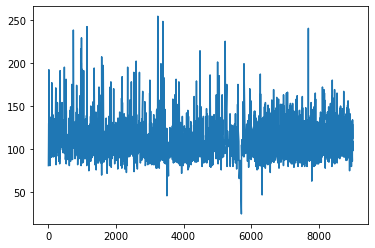

In [33]:
plt.plot(dfm_cluster.runtime)

In [34]:
cluster_features = cluster_features[cluster_features.runtime >= 40]
cluster_features = cluster_features[cluster_features.runtime <= 240]

On regarde la proportion de films pour lesquels certains champs n'ont pas été renseignés.

In [35]:
print("Nombre de films retenus dans cluster_features : ", len(cluster_features))
print("Parmi ces films :")
print(len(cluster_features[cluster_features.genres == "[]"]), "n'ont pas de genres")
print(len(cluster_features[cluster_features.keywords == "[]"]), "n'ont pas de keywords")
print(len(cluster_features[cluster_features.production_countries == "[]"]), "n'ont pas de production_countries")
print(len(cluster_features[cluster_features.crew == "[]"]), "n'ont pas de crew")

Nombre de films retenus dans cluster_features :  3390
Parmi ces films :
1 n'ont pas de genres
110 n'ont pas de keywords
24 n'ont pas de production_countries
0 n'ont pas de crew


Il s'agit d'une petite proportion, on peut donc retirer ces films problématiques.

In [36]:
cluster_features = cluster_features[cluster_features.genres != "[]"]
cluster_features = cluster_features[cluster_features.keywords != "[]"]
cluster_features = cluster_features[cluster_features.production_countries != "[]"]
print("Nombre de films dans cluster_features : ", len(cluster_features))

Nombre de films dans cluster_features :  3265


On peut maintenant se concentrer sur le traitement des données de chacune des colonnes. Il faut les simplifier au maximum pour rendre possible la comparaison de films basée sur ces attributs.

In [37]:
def vectorize_genres(genres):
    
    if isinstance(genres, str):
        pattern = re.compile(r"'id': [0-9]*")
        return np.array([int(w[6:]) for w in pattern.findall(genres)])
    
    return genres

In [38]:
cluster_features.genres = cluster_features.genres.apply(vectorize_genres)

In [39]:
def vectorize_keywords(keywords):
    
    if isinstance(keywords, str):
        pattern = re.compile(r"'id': [0-9]*")
        return np.array([int(w[6:]) for w in pattern.findall(keywords)])
    
    return keywords

In [40]:
cluster_features.keywords = cluster_features.keywords.apply(vectorize_keywords)

In [41]:
def find_director(crew):
    
    if isinstance(crew, str):
        start = crew.find('\"Director\"')+21
        new = crew[start:]
        end = new.find("\"")
        director = new[:end]
        return director
    
    return crew

In [42]:
cluster_features = cluster_features.rename(columns={'crew' : 'director'})
cluster_features.director = cluster_features.director.apply(find_director)

In [43]:
def simplify_date(date):
    
    if isinstance(date, str):
        return int(date[:4])
    
    return date

In [44]:
cluster_features.release_date = cluster_features.release_date.apply(simplify_date)

In [45]:
def simplify_countries(countries):
    
    if isinstance(countries, str):
        pattern = re.compile(r"'iso_3166_1': ...")
        return [w[15:] for w in pattern.findall(countries)]
    
    return genres

In [46]:
cluster_features.production_countries = cluster_features.production_countries.apply(simplify_countries)

In [47]:
cluster_features.head()

,title,movieId,genres,keywords,director,release_date,production_countries,original_language,runtime
0,Toy Story,1,"[16, 35, 10751]","[931, 4290, 5202, 6054, 9713, 9823, 165503, 17...",John Lasseter,1995,[US],en,81.0
9,GoldenEye,10,"[12, 28, 53]","[701, 769, 1308, 2812, 3268, 3272, 3278, 3376,...",Martin Campbell,1995,"[GB, US]",en,130.0
10,The American President,11,"[35, 18, 10749]","[833, 840, 1605, 33476, 211505]",Rob Reiner,1995,[US],en,106.0
13,Nixon,14,"[36, 18]","[840, 2946, 4240, 5565, 6086, 6165]",Oliver Stone,1995,[US],en,192.0
14,Cutthroat Island,15,"[28, 12]","[911, 1454, 1969, 3799, 5470, 12988]",Renny Harlin,1995,"[FR, DE, IT, US]",en,119.0


### Définition d'une distance sur les films

In [48]:
MAX_YEAR_DIFFERENCE = max(cluster_features.release_date) - min(cluster_features.release_date)
MAX_RUNTIME_DIFFERENCE = max(cluster_features.runtime) - min(cluster_features.runtime)

Cette fonction calcule les similarités entre 2 films. Plus les valeurs sont proches de 0, plus les films ont de points communs et plus elles sont proches de 1, plus ils sont différents (peut-être changer le nom ? instinctivement, j'aurais pensé que pour être très similaire il fallait un score élevé REPONSE : il s'agit d'une distance)

discuter de la manière de les calculer ?

In [49]:
def movie_distance(m1, m2, w_gen=3, w_key=4, w_dir=4, w_rel=2, w_pro=2, w_ori=1, w_run=1):
    
    sum_vect = 0
    # SIMILARITIES IN GENRES
    g1 = m1.genres
    g2 = m2.genres
    gen = np.append(g1, g2)
    sum_vect += (w_gen * (1 - (len(gen) - len(np.unique(gen))) / min(len(g1), len(g2)))) ** 2
        
    # SIMILARITIES IN KEYWORDS
    kw1 = m1.keywords
    kw2 = m2.keywords
    kw = np.append(kw1, kw2)
    sum_vect += (w_key * (1 - (len(kw) - len(np.unique(kw))) / min(len(kw1), len(kw2)))) ** 2
    
    # SIMILARITIES FOR THE DIRECTOR
    if m1.director != m2.director:
        sum_vect += (w_dir * 1) ** 2  # CHANGER PEUT ETRE
        
    #SIMILARITIES FOR THE RELEASE DATE
    sum_vect += (w_rel * abs(m1.release_date - m2.release_date) / MAX_YEAR_DIFFERENCE) ** 2
    
    #SIMILARITIES IN PRODUCTION COUNTRIES
    pc = []
    pc1 = m1.production_countries
    pc.extend(pc1)
    pc2 = m2.production_countries
    pc.extend(pc2)
    pc_dist = 1 - (len(pc) - len(np.unique(pc))) / min(len(pc1), len(pc2))
    if 'US' not in pc1 and 'US' not in pc2 and pc_dist > 0.5:
        sum_vect += (w_pro * 0.5) ** 2
    else:
        sum_vect += (w_pro * pc_dist) ** 2
    
    #SIMILARITIES FOR THE LANGUAGE
    lang1 = m1.original_language
    lang2 = m2.original_language
    if lang1 != lang2 :
        if lang1 != 'en' and lang2 != 'en':
            sum_vect += (w_ori * 0.4) ** 2
        else:
            sum_vect += (w_ori * 1) ** 2
    
    #SIMILARITIES FOR THE RUNTIME
    sum_vect += (w_run * abs(m1.runtime - m2.runtime) / MAX_RUNTIME_DIFFERENCE) ** 2
    
    return np.sqrt(sum_vect)

La fonction compute_dist_matrix calcule la distance séparant chaque paire de films du DataFrame passé en argument. Cependant elle ne renvoit pas une matrice, mais un pd Series avec un double index (l'id de 2 films).

In [50]:
def compute_dist_matrix(clu_fea):
    
    movies_id = clu_fea.movieId.apply(lambda x: str(x))
    dist_mat = pd.DataFrame(np.nan * len(clu_fea), index=movies_id, columns=movies_id)
    for i in range(len(clu_fea)):
        for j in range(i, len(clu_fea)):
            if i == j:
                dist_mat.iat[i, j] = 1000
            else:
                dist_mat.iat[i, j] = dist_mat.iat[j, i] = movie_distance(clu_fea.iloc[i], clu_fea.iloc[j]) # ICI
    
    return dist_mat

On s'intéresse ici au Agglomerative Hierarchical Clustering. On n'a pas besoin de préciser le nombre de clusters attendus, à la place on obtient un dendrogramme.

In [51]:
class dendrogram:
    def __init__(self, leaf=None):
        self.leaf = leaf
        self.leaf_nb = 1
        self.father = None
        self.left = None
        self.right = None
    
    def set_leaf_nb(self):
        total_leaf_nb = 0
        if self.left is not None:
            total_leaf_nb += self.left.leaf_nb
        if self.right is not None:
            total_leaf_nb += self.right.leaf_nb
        self.leaf_nb = max(1, total_leaf_nb)
    
    def get_id_list(self):
        id_list = []
        def prefix(node):
            if node.leaf is not None:
                id_list.append(node.leaf)
            else:
                prefix(node.right)
                prefix(node.left)
        prefix(self)
        
        return id_list
    
    def get_root(self):
        tmp = self
        while tmp.father is not None: tmp = tmp.father
            
        return tmp
    
    def get_n_clusters(self, n):
        cluster_list = []
        outliers = []
        error = []
        def step(node, n):
            if n == 1:
                cluster_list.append(node.get_id_list())
            elif node.left is None or node.right is None:
                error.append(True)
            else:
                prop_left = node.left.leaf_nb / node.leaf_nb
                prop_right = node.right.leaf_nb / node.leaf_nb
                if prop_left < 0.15:
                    outliers.extend(node.left.get_id_list())
                    step(node.right, n)
                elif prop_right < 0.15:
                    outliers.extend(node.right.get_id_list())
                    step(node.left, n)
                else:
                    n_left = max(1, round(n * prop_left))
                    if n_left == n:
                        n_left -= 1
                    n_right = n - n_left
                    step(node.left, n_left)
                    step(node.right, n_right)
        step(self, n)
        if error:
            print("n too big")
        else:
            return cluster_list, outliers

On ajoute un attributs dendrogram aux films sélectionnés. Au départ, chaque film est isolé. Ensuite on construit le dendrogramme étape par étape en connectant les films les plus proches (on les regroupe dans un même cluster).

In [52]:
def clusterize(dist_mat, clu_fea):
    
    clu_fea["dendrogram"] = clu_fea.movieId.apply(lambda x: dendrogram(leaf=x))
    size_mat = len(clu_fea)
    for cpt in range(1, size_mat):
        index_str1, index_str2 = dist_mat.stack().idxmin()
        index1, index2 = int(index_str1), int(index_str2)
        mov1 = clu_fea[clu_fea.movieId == index1].iloc[0]
        mov2 = clu_fea[clu_fea.movieId == index2].iloc[0]
        tmp1 = mov1.dendrogram
        tmp2 = mov2.dendrogram
        while tmp1.father is not None: tmp1 = tmp1.father
        while tmp2.father is not None: tmp2 = tmp2.father
        tmp3 = dendrogram()
        tmp3.left = tmp1
        tmp3.right = tmp2
        tmp3.set_leaf_nb()
        tmp1.father = tmp3
        tmp2.father = tmp3
        new_d = np.maximum(dist_mat.loc[index_str1, :], dist_mat.loc[index_str2, :])
        dist_mat.loc[index_str1, :] = dist_mat.loc[:, index_str1] = new_d
        dist_mat = dist_mat.drop(index_str2, axis=0)
        dist_mat = dist_mat.drop(index_str2, axis=1)
    
    return clu_fea.iloc[0].dendrogram.get_root()

In [53]:
def get_cluster(clu_fea, id_list):
    df = pd.DataFrame([])
    for i in id_list:
        df = df.append(clu_fea[clu_fea.movieId == i])
    
    return df

In [54]:
def get_clusters_size(clu_fea, id_list_list):
    for id_list in id_list_list:
        print(len(id_list))

Test sur un échantillon de taille 10

In [55]:
test_10 = cluster_features.sample(10)
start_time = time()
dist_mat_test_10 = compute_dist_matrix(test_10)
print("Temps d'execution : %s secondes ---" % (time() - start_time))

Temps d'execution : 0.08421540260314941 secondes ---


In [56]:
start_time = time()
root_test_10 = clusterize(dist_mat_test_10.copy(), test_10)
print("Temps d'execution : %s secondes ---" % (time() - start_time))

Temps d'execution : 0.11606192588806152 secondes ---


Test sur un échantillon de taille 100

In [57]:
test_100 = cluster_features.sample(100)

In [58]:
start_time = time()
dist_mat_test_100 = compute_dist_matrix(test_100)
print("Temps d'execution : %s secondes ---" % (time() - start_time))

Temps d'execution : 6.990323305130005 secondes ---


In [59]:
#%lprun -f movie_distance compute_dist_matrix(test_100)

In [60]:
start_time = time()
root_test_100 = clusterize(dist_mat_test_100.copy(), test_100)
print("Temps d'execution : %s secondes ---" % (time() - start_time))

Temps d'execution : 0.9009990692138672 secondes ---


In [61]:
#%lprun -f clusterize clusterize(dist_mat_test_100.copy(), test_100)

In [62]:
clusters, outliers = root_test_100.get_n_clusters(5)
print(len(outliers), 'outliers')
get_clusters_size(cluster_features, clusters)

15 outliers
5
18
28
9
25


In [63]:
get_cluster(cluster_features, outliers)

,title,movieId,genres,keywords,director,release_date,production_countries,original_language,runtime
6140,March of the Penguins,34072,"[99, 10751]","[970, 3028, 4260, 4970, 5698, 10349, 10794, 15...",Luc Jacquet,2005,[FR],fr,80.0
6304,Hoodwinked!,42734,"[16, 35, 10751]","[1994, 3301, 4174, 5340, 11728]",Cory Edwards,2005,[US],en,80.0
1811,Antz,2294,"[12, 16, 35, 10751]","[1402, 1701, 2346, 3126, 3640, 4967, 6091, 737...",Eric Darnell,1998,[US],en,83.0
2880,Dinosaur,3615,"[16, 10751]","[843, 1423, 3077, 4803, 10336, 10506, 10789, 1...",Ralph Zondag,2000,[US],en,82.0
2395,For Your Eyes Only,2989,"[12, 28, 53]","[212, 339, 392, 658, 782, 1262, 1568, 2070, 21...",John Glen,1981,"[GB, US]",en,127.0
6796,The Golden Compass,56171,"[12, 14]","[392, 1461, 1706, 2596, 6464, 6678, 13014, 181...",Chris Weitz,2007,"[GB, US]",en,113.0
5940,Tae Guk Gi: The Brotherhood of War,27869,"[28, 12, 18, 36, 10752]","[41586, 158534, 158538, 158540, 158547, 158553]",Kang Je-gyu,2004,[KR],ko,140.0
4974,Hero,7090,"[18, 12, 28, 36]","[548, 1014, 6145, 54324]",Zhang Yimou,2002,[CN],zh,99.0
1972,Crocodile Dundee,2470,"[12, 35]","[242, 549, 612, 736, 1463, 1552, 3185, 3593, 4...",Peter Faiman,1986,[AU],en,97.0
8288,The Best Offer,103235,"[18, 10749, 80, 9648]","[5918, 198318, 201385, 220933, 221810]",Giuseppe Tornatore,2013,[IT],en,124.0


Données complètes

In [64]:
start_time = time()
dist_mat = compute_dist_matrix(cluster_features) # environ 45 minutes
print("Temps d'execution : %s secondes ---" % (time() - start_time))

KeyboardInterrupt: 

In [ ]:
start_time = time()
root = clusterize(dist_mat, cluster_features) # environ 15 minutes
print("Temps d'execution : %s secondes ---" % (time() - start_time))

In [ ]:
clusters, outliers = root.get_n_clusters(8)
print(len(outliers), 'outliers')
get_clusters_size(cluster_features, clusters)

In [ ]:
get_cluster(cluster_features, outliers)

# Hybride cluster collabo

In [ ]:
def find_cluster (movieId) :#l'utilisateur uid veut une liste de films qu'il aimerait et ressemblent à movieId
    movieId = str(movieId)
    for i in range(1,len(cluster.get_clusters_size())) :
        if movieId in cluster.get_cluster(i).index :
            return cluster.get_cluster(i)
    return ("Le film n'existe pas")

In [ ]:
def hyb(uid,mid,nb_reco=10,base="user",k=4):
    '''
    Suggère à l'utilisateur uid le top nb_reco de films qui ressemblent au film mid (car dans le même cluster) 
    qu'il est le plus susceptible d'apprécier (en trouvant les notes grâce à predict_collabo)
    '''
    
    predictions = pd.DataFrame(columns=['movieId', 'predict_rating'])
    cluster = find_cluster(mid)
    for movie in cluster.index :
        p, o = (uid, movie) if base == 'user' else (movie, uid)
        rat = predict_collabo(p, o, base, k)
        predictions = predictions.append({'movieId':int(movie), 'predict_rating':rat}, ignore_index=True)
    predictions = predictions.sort_values(by='predict_rating', ascending=False)
    reco = predictions.head(nb_reco) if predictions.shape[0] > nb_reco else predictions
    return cluster.merge(reco, how='inner')

In [ ]:
find_cluster(1)

In [ ]:
for movie in find_cluster(1).index :
    print(movie)

## Model-based recommendation system

La matrice des notes user-item $R$ est partiellement vide. Ainsi réduire les dimensions de la matrice pourrait améliorer la complexité de nos algorithmes. Une méthode que nous pourrions avoir envie d'utiliser est la décomposision en valeurs singulières : $R = U_{svd} \Sigma V_{svd}^T$. Cependant cette méthode ne s'applique pas ici étant donné que $R$ n'est pas complète et qu'on a besoin de réaliser des calculs algébriques avec $R$ pour trouver la décomposition.

On considère donc un modèle dans lequel il existe des attributs décrivants les films et les préférences des utilisateurs. La matrice $R$ peut alors être factorisée en produit de deux matrices $U$ et $V$ représentant respectivement les utilisateurs et les items :

$$
R \approx U \times V^T
$$

avec $R \in \mathbb{R}^{n \times m}$ la matrice des notes user-item, $U \in \mathbb{R}^{n \times \ell}$ la matrice des users, $V \in \mathbb{R}^{m \times \ell}$ la matrice des items et $\ell$ le nombre d'attributs. Pour faire un rapprochement avec la SVD, on peut considerer que $U = U_{svd} \Sigma^{1/2}$ et $V = \Sigma^{1/2} V_{svd}^T$. On note $U_i$ les lignes de $U$ et $V_j$ les lignes de $V$ :
$
U = \left[ \begin{array}{c} U_1 \\ \vdots \\ U_n \end{array} \right]
$ et 
$
V = \left[ \begin{array}{c} V_1 \\ \vdots \\ V_m \end{array} \right]
$
avec $U_i^T, V_j^T \in \mathbb{R^\ell}$.

Dans ce modèle, chaque note $R_{ij}$ associée à un couple user-item $(i, j)$ est le résultat du produit scalaire entre la ligne associée au user $i$ dans $U$ et la ligne associée au item $j$ dans $V$ : $R_{ij} = U_i \cdot V_j^T$. Une fois les matrices $U$ et $V$ apprises, pour prédire une note il suffira de faire le produit scalaire entre les lignes associées.

Trouver $U$ et $v$ revient à minimiser l'erreur entre la note prédite $U_i \cdot V_j^T$ et la véritable note $R_{ij}$. Il s'agit du problème de minimisation suivant, avec $E = \{(i, j) \mbox{ | } R_{ij} \mbox{ connue}\}$ :

$$
(U, V) = argmin_{(U, V)} \sum_{(i, j) \in E} [U_i \cdot V_j^T - R_{ij}]^2
$$

qui est équivalent à:

$$
(U, V) = argmin_{(U, V)} \frac{1}{2}\sum_{(i, j) \in E} [U_i \cdot V_j^T - R_{ij}]^2 + \lambda (\|U_i\|^2 + \|V_j\|^2)
$$

Le terme de droite est un terme régulateur, de paramètre $\lambda$ à ajuster, permettant de prévenir un overfitting.

Pour résoudre ce problème, nous allons utiliser une méthode de descente de gradient.


*Pour résoudre ce problème, on peut utiliser une méthode de descente de gradient. Nous allons ensuite optimiser cette méthode en utilisant d'abord des batch, puis en se réduisant à un problème de moindre carré en fixant alternativement les matrices $U$ et $V$.*

### Descente de gradient (à pas constant)

Dans notre [cours d'optimisation](https://www.ceremade.dauphine.fr/~gontier/enseignement.html) donné par David Gontier, nous avons étudié différentes méthodes de descente de gradient de complexité et d'optimalité différentes. Cependant il nous semble qu'utiliser une version simple à pas $\tau$ constant suffit. Il sera possible de régler cet hyper-paramètre par validation croisée. 

Notre fonction objective est la suivante :
$$
F(U, V) := \sum_{(i, j) \in E} \frac{1}{2}[U_i \cdot V_j^T - R_{ij}]^2 + \frac{\lambda}{2} (\|U_i\|^2 + \|V_j\|^2)
$$

Dans une descente de gradient classique, à chaque itération on met à jour $U$ et $V$ suivant la formule 
$
(U, V) = (U, V) - \tau \nabla F(U, V)
$. Cependant, dans notre cas nous n'allons pas mettre à jour toutes les lignes de $U$ et $V$ simultanément. En effet, puisque la somme dans $F$ ne se fait que sur les couples $(i, j)$ pour lesquels la note est connue, nous allons seulement mettre à jour le couple $(U_i, V_j)$ associé en itérant sur tous les couples $(i, j) \in E$. 

Pour une note $R_{ij}$, on a 
$
\frac{\partial F}{\partial U_i} = V_j^T (U_i \cdot V_j^T - R_{ij}) + \lambda U_i
$
 et 
$
\frac{\partial F}{\partial V_j} = Ui (U_i \cdot V_j^T - R_{ij}) + \lambda V_j
$
donc on peut mettre à jour les lignes $U_i$ et $V_j$ selon les formules 
$$
U_i = Ui - \tau [V_j^T (U_i \cdot V_j^T - R_{ij}) + \lambda U_i]\\
V_j = V_j - \tau [Ui (U_i \cdot V_j^T - R_{ij}) + \lambda V_j]
$$

In [ ]:
class ModelBasedPredictor:
    def __init__(self):
        self.R = None
        self.E = None
        self.U = None
        self.V = None
        self.user_id = None
        self.movie_id = None
        self.user_rank = None
        self.movie_rank = None
    
    def fit(self, ratings, ell=10, lamb=1/2, tau=1/10, tol=1e-3, Niter=1000, verbose=False):
        if verbose:
            logger = logging.getLogger()
            logger.setLevel(logging.INFO)
        
        dfr = ratings[['userId', 'movieId', 'rating']]

        # correspondance rang - id
        self.user_id = dfr['userId'].unique().tolist()
        self.movie_id = dfr['movieId'].unique().tolist()
        self.user_id.sort()
        self.movie_id.sort()
        # correspondance id - rang
        self.user_rank, self.movie_rank = {}, {}
        for uid in self.user_id:
            self.user_rank[uid] = len(self.user_rank)
        for mid in self.movie_id:
            self.movie_rank[mid] = len(self.movie_rank)

        # transformer la dataframe en matric numpy
        dfr.set_index(['userId', 'movieId'], inplace=True)
        self.R = dfr.unstack(level='movieId').to_numpy()

        # construction de l'ensemble E, ensemble des rangs pour lesquels R[i, j] est connu
        ids = list(dfr.index)
        self.E = list(map(lambda t : (self.user_rank[t[0]], self.movie_rank[t[1]]), ids)) 

        n = len(self.user_rank)
        m = len(self.movie_rank)

        self.U, self.V = np.random.rand(n, ell), np.random.rand(m, ell)
        self._descenteGradient_(lamb, tau, tol, Niter, verbose)
        
    def predict(self, uid, mid):
        assert self.E is not None, "This ModelBasedPredictor instance is not fitted yet. \
                                                Call 'fit' with appropriate arguments before using this estimator."
        ell = self.U.shape[1]
        
        u = self.U[self.user_rank[uid]] if uid in self.user_rank else np.random.rand(ell)
        v = self.V[self.movie_rank[mid]] if mid in self.movie_rank else np.random.rand(ell)
        

        pred = np.dot(u, v.T)
        # note prédite à une précision de 0.5
        pred = round(2 * pred) / 2
        # note prédite se trouve entre 0 et 5
        pred = 5 if pred > 5 else pred
        pred = 0 if pred < 0 else pred
        return pred

    
    def score(self, test_ratings):
        assert self.E is not None, "This ModelBasedPredictor instance is not fitted yet. \
                                                Call 'fit' with appropriate arguments before using this estimator."
        
        dft = test_ratings.set_index(['userId', 'movieId'])
        predictions = [self.predict(uid, mid) for (uid, mid) in list(dft.index)]
        truth = dft['rating'].to_numpy()
    
        print(predictions)
        print(truth)
        
        return 1 - math.sqrt(sum((predictions - truth)**2)) / 5
             
    def _norm2_(self, X):
        return sum([X[i]**2 for i in range(len(X))])

    def _F_(self, lamb):
        return sum([1/2 * (np.dot(self.U[i], self.V[j].T) - self.R[i, j])**2 \
                    + lamb/2 * (self._norm2_(self.U[i]) + self._norm2_(self.V[j]))  for (i, j) in self.E])
    
    def _descenteGradient_(self, lamb, tau, tol=1e-3, Niter=1000, verbose=False):
        R = self.R
        E = self.E
        U, V = self.U, self.V
        
        if verbose:
            logging.info('nombre de couples : {}'.format(len(E)))
            logging.info("nombre d'iteration max : {}".format(Niter))
            
        last_F = 0
        for n in range(Niter):

            new_F = self._F_(lamb)

            if verbose :
                logging.info("{}. pente de F: {}".format(n, abs(new_F - last_F)))

            if abs(new_F - last_F) < tol:
                return
            last_F = new_F   

            for (i, j) in E:
                gradU = V[j].T * (np.dot(U[i], V[j].T) - R[i, j]) + lamb * U[i]
                gradV = U[i] * (np.dot(U[i], V[j].T) - R[i, j]) + lamb * V[j]
                U[i] -= tau * gradU
                V[j] -= tau * gradV
        print("Erreur, l’algorithme n’a pas convergé après", Niter ," itérations")

In [ ]:
model = ModelBasedPredictor()
%time model.fit(ratings.sample(1000), verbose=True)

Il se peut que tous les entiers entre 1 et $n$ (ou $m$) ne soient pas utlisés par les id des users (ou des movies). Ceci est par exemple le cas lorsqu'on travaille avec un échantillon des données ou que des lignes ont été supprimées lors d'un nettoyage des données. Puisque nous aimerions utiliser des numpy array dans nos calculs, il va être nécessaire d'avoir la correspondance entre les id et les indices utilisés dans les numpy array (les indices seront appelés rang pour éviter une orthographe trop similaire). Pour cela, nous utilisons une liste `user_id` qui pour un rang donné permet d'avoir l'id correspondant : `user_id[i] = uid` où `i` est le rang correspondant à l'id `uid`. Pour avoir la correspondance dans l'ordre sens, nous utilisons un dictionnaire `user_rank` : `user_rank[uid] = i`.

La matrice $R$ étant vide, nous n'allons pas utiliser de matrice pour la représenter et garderons la dataframe qui ne contient que les notes connues. Nous allons également avoir besoin d'écrire une fonction `get_rat()` qui permet d'accéder à la note d'un couple de rang dans la dataframe des notes. Nous utilisons également une fonction `known()` pour construire l'ensemble $E$.

Nous pouvons à présent écrire la fonction résolvant notre problème de minimisation. Remarquons qu'elle modifie les valeurs de $U$ et $V$ en place.

### Validation croisée : estimer le score

Principe : blablabla

score de validation croisée == moyenne des score des k sous echantillons

source : cours de Joon Kwon CPES2 + https://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
ratings.shape

In [ ]:
def split_train_test(df, train_prop, seed=None):
    '''
    Sépare la dataframe df en deux dataframe train et test.
    :param: df la dataframe à séparer
            train_prop la proportion d'element qu'il doit y avoir dans le train dataframe
            seed la graine du générateur aléatoire
    :return: les train et test dataframes
    '''
    train = df.sample(frac=train_prop, random_state=seed) if seed else df.sample(frac=train_prop)
    test = df.drop(train.index)
    return train, test

In [ ]:
def k_fold(df, nb_folds, seed=None):
    '''
    Sépare la dataframe df en nb_folds dataframe de taille (presque) égales.
    :param: df la dataframe à séparer
            nb_folds le nombre d'échantillons à consitutuer à partir de df
            seed la graine du générateur aléatoire
    :return: la liste des dataframes
    '''
    N = len(df)
    f_size = N // nb_folds
    folds = [None] * nb_folds
    for i in range(nb_folds - 1):
        folds[i] = df.sample(n=f_size, random_state=seed) if seed else df.sample(n=f_size)
        df = df.drop(folds[i].index)
    folds[nb_folds - 1] = df
    return folds

In [ ]:
dfr = ratings.sample(100)
train, test = split_train_test(dfr, 0.8)
model = ModelBasedPredictor()
model.fit(train)
score = model.score(test)
print(score)

In [ ]:
def cross_validation(predictor, df, params, nb_folds, seed=None):
    
    # verification que les arguments donnés dans le dictionnaire params correspondent bien aux paramètre de predictor
    var = getattr(getattr(predictor.fit, '__code__'), 'co_varnames')
    assert set(params.keys()) <= set(var[1:]), 'invalid arguments given in params' # var[1:] pour enlever 'self'
    
    
    folds = k_folds(df, nb_folds, seed)
    scores = [None] * nb_folds
    
    for i in range(nb_folds):
        train
        f = folds[i]
        
        pred = predictor()
        pred.fit(train, **params)
        scores[i] = pred.score(f)
    
    
    
    return sum(scores) / nb_folds

### Choix des hyperparamètres

2 params à tuner : lambda et tau

pour cela on va faire des tests de manière exhaustives sur une grille de différentes valeurs d'hyperparamètre (grid search)
Pour chaque couple de valeurs d'hyperparametre, on calcul le score par validation croisée

In [ ]:
def gridSearch():
    None

In [ ]:
lamb in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
learning_rate in [0.001, 0.01, 0.1]

## Linear model : content-based

On remarque que si $U$ ou $V$ est fixé, la fonction objective devient quadratique. Or nous connaissons des algorithmes efficaces pour minimiser des fonctions quadratiques. De plus, une matrice d'attributs des films peut être donnée puisqu'on connaît certaines informations sur les films.